# Show a nice Spectrum


The spectra has been reconstructed by Spectractor.
The Spectra in pickles files


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : August 18th 2022





# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/41g16069m_tmg.fits',
 'comptable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/49i2235im_tmc.fits',
 'thermtable': '/sps/lsst/groups/auxtel/softs/utils/PySynPhotData/grp/hst/cdbs/mtab/3241637sm_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [4]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Functions

In [6]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [7]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [8]:
def GetSpectra(dict_spectra):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    for key, value in dict_spectra.items():
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]
        df["all_fluxes_err"] = value["all_fluxes_err"]
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [9]:
def ConvertToImage(info, all_df,WLMIN=350,WLMAX=1100):
    """
    
    call 
    WL,Mags1,EMags1,AirM,Tim = ConvertToImage(info,all_spectra,WLMIN= WLMINSEL ,WLMAX= WLMAXSEL)
    
    
    
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))   # table of  magnitudes
    emag_table=np.zeros((N,NWL))  # table of error on magnitudes
    
    
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        mag = -2.5*np.log10(df["all_fluxes"])
        errmag = 2.5/np.log(10) * df["all_fluxes_err"]/df["all_fluxes"]
        wavelength = df["all_lambdas"]
        fcn = interpolate.interp1d(wavelength,mag,bounds_error=False,fill_value=(0,0))
        fcn2 = interpolate.interp1d(wavelength,errmag,bounds_error=False,fill_value=(0,0))
            
        mag_table[idx,:] = fcn(WL) 
        emag_table[idx,:] = fcn2(WL) 
        
        airm_table[idx]  = info["airmass"].iloc[idx]
        time_table[idx]  = info["refhour"].iloc[idx]
        
    return WL, mag_table, emag_table,airm_table,time_table
       

In [10]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    for key, value in dict_spectra.items():
        
        
        if int(value["number"]) not in list_of_bad_spectra:
            
            num = int(value["number"])
            msg = f"Keep spectrum {idx} for exposure {num}"
            print(msg)
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]
            df["all_fluxes_err"] = value["all_fluxes_err"]
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

# Constants

# Initialisation

In [11]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [12]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2022-08-18 15:26:32,118 jns-dagoret.cc.in2p3.fr __main__[3979] INFO LA time:06:26:32
2022-08-18 15:26:32,120 jns-dagoret.cc.in2p3.fr __main__[3979] INFO NY time:09:26:32
2022-08-18 15:26:32,122 jns-dagoret.cc.in2p3.fr __main__[3979] INFO London time:14:26:32
2022-08-18 15:26:32,124 jns-dagoret.cc.in2p3.fr __main__[3979] INFO Paris time:15:26:32
2022-08-18 15:26:32,125 jns-dagoret.cc.in2p3.fr __main__[3979] INFO ************************ START *********************


In [13]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [14]:
!ls config

auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini
confprog_run-auxtel-holo-20220316-configFFM.ini


In [15]:
# config file
# --------------
#configfile = "config/default.ini"
configfile = "config/confprog_run-auxtel-holo-20220316-configFFM.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2022-08-18 15:26:33,228 jns-dagoret.cc.in2p3.fr __main__[3979] INFO Configuration file : config/confprog_run-auxtel-holo-20220316-configFFM.ini


In [16]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2022-08-18 15:26:33,250 jns-dagoret.cc.in2p3.fr __main__[3979] INFO 1) Configuration


In [17]:
config_section = config.sections()

In [18]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [19]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    outputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    outputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [20]:
msg=f" Object observed {target} at {SITE} ({DATE})"
logger.info(msg)

2022-08-18 15:26:33,319 jns-dagoret.cc.in2p3.fr __main__[3979] INFO  Object observed ETA1 DOR at AUXTEL/Rubin Obs (2022-03-16)


In [21]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [22]:
inputfile

'run-auxtel-holo-20220316-config_DECONVOLUTION_PSF2DFFM.pickle'

In [23]:
list_of_badnums = [int(nn)  for nn in BADEXPOS.split()]

list_of_badnums

[352, 259, 358, 365, 272, 394, 421, 427, 434, 435]

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [24]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [25]:
sed_w=s0.wave/10
sed_f=s0.flux*10*normalisationfactor
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [26]:
sed_m=-2.5*np.log10(sed_f)

## spectrum data

In [27]:
fullfilename=os.path.join(inputdir,inputfile)

In [28]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [29]:
NBSPECTRA=len(summary_content)

In [30]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2022-08-18 15:26:33,463 jns-dagoret.cc.in2p3.fr __main__[3979] INFO  Number of selected files is 24


In [31]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [32]:
info, all_spectra  = GetSpectraFiltered(summary_content,list_of_badnums)

Keep spectrum 0 for exposure 330
Keep spectrum 1 for exposure 331
Keep spectrum 2 for exposure 337
Keep spectrum 3 for exposure 338
Keep spectrum 4 for exposure 344
Keep spectrum 5 for exposure 345
Remove spectrum 6 for exposure 352
Remove spectrum 7 for exposure 259
Remove spectrum 8 for exposure 358
Remove spectrum 9 for exposure 365
Remove spectrum 10 for exposure 272
Keep spectrum 11 for exposure 372
Keep spectrum 12 for exposure 373
Keep spectrum 13 for exposure 379
Keep spectrum 14 for exposure 380
Keep spectrum 15 for exposure 386
Keep spectrum 16 for exposure 387
Remove spectrum 17 for exposure 394
Keep spectrum 18 for exposure 400
Keep spectrum 19 for exposure 401
Remove spectrum 20 for exposure 421
Remove spectrum 21 for exposure 427
Remove spectrum 22 for exposure 434
Remove spectrum 23 for exposure 435


In [33]:
info

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,330,ETA1 DOR,2022-03-17T01:59:23.629,0.000000,1.385782,743.55,10.6,44.0,exposure_2022031600330_postisrccd_spectrum.fits,310.615334,1735.907975,-0.280035,178.693845
1,331,ETA1 DOR,2022-03-17T01:59:56.544,0.009143,1.386861,743.55,10.6,44.0,exposure_2022031600331_postisrccd_spectrum.fits,316.273156,1738.624351,0.153940,185.036704
2,337,ETA1 DOR,2022-03-17T02:02:50.136,0.057363,1.392651,743.55,10.6,43.0,exposure_2022031600337_postisrccd_spectrum.fits,314.432940,1734.336233,0.178178,184.794495
3,338,ETA1 DOR,2022-03-17T02:03:23.224,0.066554,1.393766,743.55,10.6,43.0,exposure_2022031600338_postisrccd_spectrum.fits,308.395298,1733.980719,0.172568,181.163842
4,344,ETA1 DOR,2022-03-17T02:06:16.878,0.114791,1.399703,743.55,10.5,43.0,exposure_2022031600344_postisrccd_spectrum.fits,307.843905,1738.650515,0.162648,181.035897
5,345,ETA1 DOR,2022-03-17T02:06:49.784,0.123932,1.400843,743.55,10.5,43.0,exposure_2022031600345_postisrccd_spectrum.fits,307.696283,1737.313990,0.169116,181.004126
11,372,ETA1 DOR,2022-03-17T02:22:24.873,0.383679,1.435249,743.55,10.5,42.0,exposure_2022031600372_postisrccd_spectrum.fits,312.546026,1740.199755,0.183910,189.196913
12,373,ETA1 DOR,2022-03-17T02:22:57.958,0.392869,1.436534,743.50,10.4,42.0,exposure_2022031600373_postisrccd_spectrum.fits,314.816770,1742.268771,0.080005,189.169850
13,379,ETA1 DOR,2022-03-17T02:25:53.644,0.441671,1.443481,743.45,10.5,42.0,exposure_2022031600379_postisrccd_spectrum.fits,315.953846,1737.071688,0.169183,184.917445
14,380,ETA1 DOR,2022-03-17T02:26:26.585,0.450821,1.444799,743.45,10.5,42.0,exposure_2022031600380_postisrccd_spectrum.fits,310.437636,1738.265491,0.175545,185.141688


In [34]:
all_spectra[0]

,all_lambdas,all_fluxes,all_fluxes_err,all_lambdas_order2,all_fluxes_order2,all_fluxes_err_order2
0,303.657233,5.842113e-09,6.604470e-11,304.372393,-3.603924e+07,2.723656e+05
1,304.014797,-3.594690e-08,4.141810e-10,304.729952,4.775623e+08,1.703656e+06
2,304.372358,8.719076e-08,1.091504e-09,305.087507,-2.217007e+09,4.482483e+06
3,304.729916,-9.443175e-08,1.531474e-09,305.445060,5.035158e+09,6.285782e+06
4,305.087472,3.538234e-08,1.540938e-09,305.802610,-5.404790e+09,6.300220e+06
...,...,...,...,...,...,...
2299,1111.830580,-3.443588e-11,3.034350e-06,1112.516459,-1.955724e+03,1.730159e+08
2300,1112.173385,-3.747172e-11,3.261962e-06,1112.859244,-2.127568e+03,1.859213e+08
2301,1112.516180,-3.986708e-11,3.437641e-06,1113.202020,-2.262888e+03,1.958576e+08
2302,1112.858966,-4.152740e-11,3.556725e-06,1113.544787,-2.356345e+03,2.025629e+08


In [35]:
NBSPECTRA=len(info)

In [36]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [37]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2022-08-18 15:26:33,670 jns-dagoret.cc.in2p3.fr __main__[3979] INFO  Number of good spectra is 14


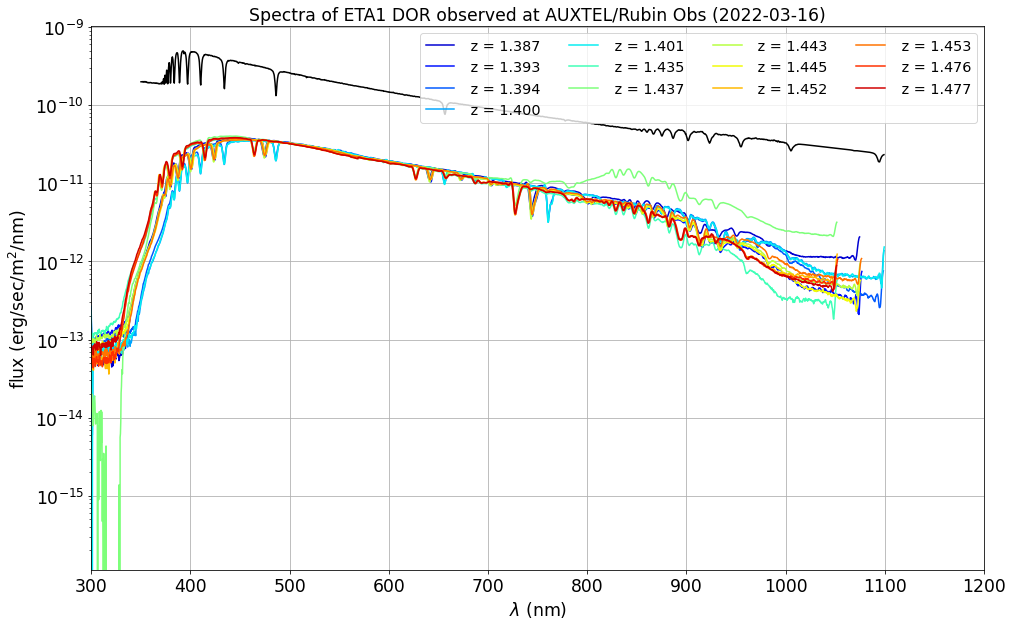

In [38]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    if ifile ==0 : 
        continue
    ax.plot(the_df.all_lambdas,the_df.all_fluxes,color=all_colors[ifile],label=label_airmass)
    #ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
#ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

# Remove bad  spectra

In [39]:
selection_cut = ((info.d2ccd > 180) & (info.d2ccd < 182)) & (info.object == "ETA1 DOR")
bad_cut = ~selection_cut

In [40]:
selection_cut

0     False
1     False
2     False
3      True
4      True
5      True
11    False
12    False
13    False
14    False
15    False
16    False
18    False
19    False
dtype: bool

In [41]:
list_of_badnums = info[bad_cut]["number"].values

In [42]:
list_of_badnums 

array([330, 331, 337, 372, 373, 379, 380, 386, 387, 400, 401])

In [43]:
selection_cut.iloc[0]

False

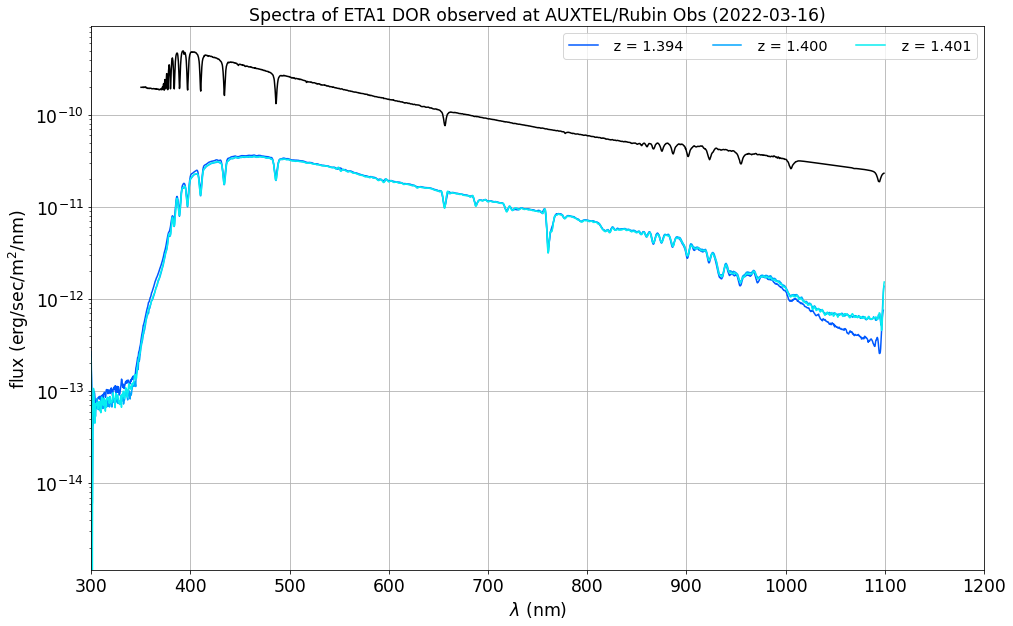

In [44]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    if ifile ==0 : 
        continue
    if selection_cut.iloc[ifile]:
       
        ax.plot(the_df.all_lambdas,the_df.all_fluxes,color=all_colors[ifile],label=label_airmass)
    #ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
#ax.set_ylim(1e-13,1e-9)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)

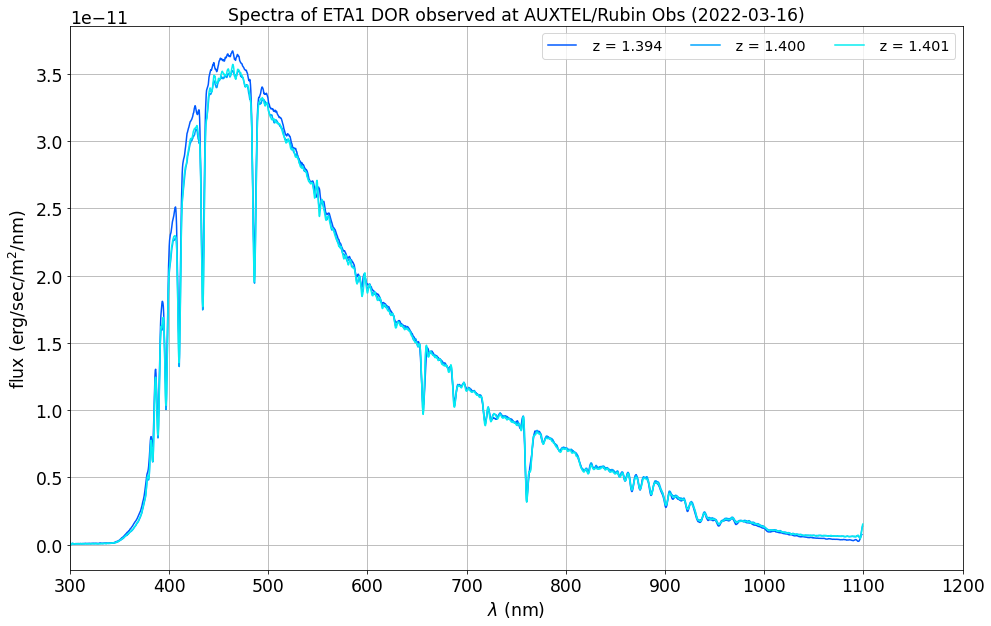

In [45]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    airmassvalue = info.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.3f}"
    if ifile ==0 : 
        continue
    if selection_cut.iloc[ifile]:
       
        ax.plot(the_df.all_lambdas,the_df.all_fluxes,color=all_colors[ifile],label=label_airmass)
    #ax.errorbar(the_df.all_lambdas,the_df.all_fluxes,yerr=the_df.all_fluxes_err, fmt = '-', color=all_colors[ifile],capsize = 0.1, ecolor=all_colors[ifile], elinewidth = .1,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Spectra of {target} observed at {SITE} ({DATE})"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1200)
#ax.set_ylim(1e-13,1e-9)
#ax.set_yscale("log")
ax.legend(loc="upper right",ncol=4)